# Examining Volunteer internal consistency

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import re
import numpy as np
import pandas as pd
import lib.galaxy_utilities as gu
from functools import partial
from gzbuilderspirals.oo import Arm
import matplotlib.pyplot as plt

In [3]:
dr8ids, ss_ids, validation_ids = np.load('lib/duplicate_galaxies.npy').T

In [4]:
print('Defining helper functions')

def get_annotations(sid):
    return gu.classifications.query(
        'subject_ids == {}'.format(sid)
    )['annotations'].apply(json.loads)

def n_drawn_comps(a, task=0):
    try:
        return len(a[task]['value'][0]['value'])
    except IndexError:
        return np.nan

def get_details(ann0, ann1, task=0):
    n_drawn0 = ann0.apply(partial(n_drawn_comps, task=task))
    n_drawn1 = ann1.apply(partial(n_drawn_comps, task=task))
    return sum(((s.mean(), s.std()) for s in (n_drawn0, n_drawn1)), ())

def get_disk_details(ann0, ann1):
    return get_details(ann0, ann1, task=0)

def get_bulge_details(ann0, ann1):
    return get_details(ann0, ann1, task=1)

def get_bar_details(ann0, ann1):
    return get_details(ann0, ann1, task=2)

def get_spiral_arm_details(ann0, ann1):
    return get_details(ann0, ann1, task=3)

Defining helper functions


In [5]:
print('Constructing classification details Data Frame')
out = []
columns = [
    '{}-{}-{}'.format(s, k, v) 
    for k in ('disk', 'bulge', 'bar', 'spiral_arms')
    for s in ('original', 'validation')
    for v in ('mean', 'std')
]
for i in range(len(dr8ids)):
    id_details = {
        'original_id': ss_ids[i],
        'validation_id': validation_ids[i],
        'dr8id': dr8ids[i],
    }
    details = np.array([
        get_details(
            get_annotations(ss_ids[i]),
            get_annotations(validation_ids[i]),
            task=j
        )
        for j in range(4)
    ])
    freq_details = {k: v for k, v in zip(columns, details.reshape(-1))}
    out.append({**id_details, **freq_details})
df = pd.DataFrame(out)

Constructing classification details Data Frame


How in-agreement were our volunteers? These plots show the variance in the percentage of volunteers drawing a component for galaxies in our original and validation subsets. The spiral arm plot shows the mean number of spiral arms for each galaxy.

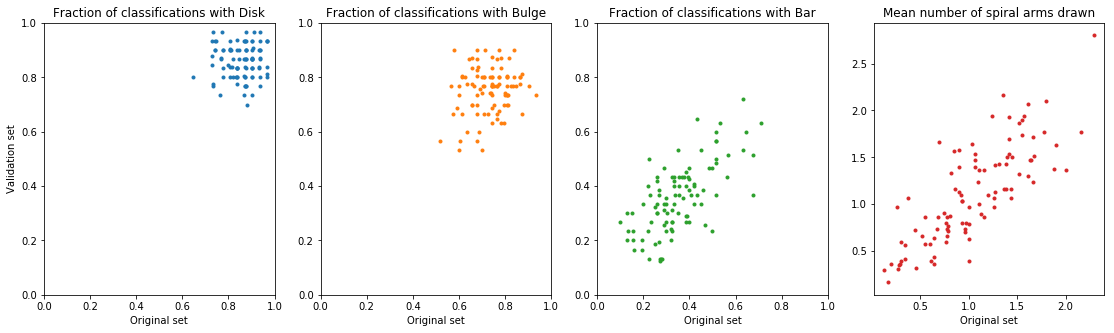

In [6]:
fig, (ax_disk, ax_bulge, ax_bar, ax_spiral) = plt.subplots(ncols=4, figsize=(19, 5))
ax_disk.plot(df['original-disk-mean'], df['validation-disk-mean'], '.', c='C0')
ax_bulge.plot(df['original-bulge-mean'], df['validation-bulge-mean'], '.', c='C1')
ax_bar.plot(df['original-bar-mean'], df['validation-bar-mean'], '.', c='C2')
ax_spiral.plot(df['original-spiral_arms-mean'], df['validation-spiral_arms-mean'], '.', c='C3')
ax_disk.set_title('Fraction of classifications with Disk')
ax_bulge.set_title('Fraction of classifications with Bulge')
ax_bar.set_title('Fraction of classifications with Bar')
for ax in (ax_disk, ax_bulge, ax_bar):
    ax.set_xlabel('Original set')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
ax_disk.set_ylabel('Validation set')

ax_spiral.set_title('Mean number of spiral arms drawn')
ax_spiral.set_xlabel('Original set')
plt.savefig('duplicates_plots/component_frequency.pdf', bbox_inches='tight')

## The aggregate model

How consistent is our aggregated model? We explore the consistency with which a component appears in our aggregated model, and how frequently we obtain a consistent number of spiral arms.

In [7]:
gzb_models = pd.read_pickle('galaxy-builder-aggregate-models.pickle')

In [8]:
original_models = gzb_models.loc[ss_ids]
validation_models = gzb_models.loc[validation_ids]
disk_agree = ~np.logical_xor(
    original_models['disk-axRatio'].notna(),
    validation_models['disk-axRatio'].notna()
)
bulge_agree = ~np.logical_xor(
    original_models['bulge-axRatio'].notna(),
    validation_models['bulge-axRatio'].notna()
)
bar_agree = ~np.logical_xor(
    original_models['bar-axRatio'].notna(),
    validation_models['bar-axRatio'].notna()
)
print('Disk agrees {:.3%} of the time'.format(disk_agree.sum() / len(disk_agree)))
print('Bulge agrees {:.3%} of the time'.format(bulge_agree.sum() / len(disk_agree)))
print('Bar agrees {:.3%} of the time'.format(bar_agree.sum() / len(disk_agree)))
print('Total model agrees {:.3%} of the time'.format(
    (disk_agree & bulge_agree & bar_agree).sum() / len(disk_agree)
))

Disk agrees 95.918% of the time
Bulge agrees 87.755% of the time
Bar agrees 75.510% of the time
Total model agrees 65.306% of the time


In [9]:
def get_n_spirals_in_model(sid):
    return len([
        f for f in os.listdir('lib/spiral_arms')
        if re.match(r'{}-[0-9]+\.pickle'.format(sid), f)
    ])
n_spirals_original = np.fromiter(map(get_n_spirals_in_model, ss_ids), dtype=int)
n_spirals_validation = np.fromiter(map(get_n_spirals_in_model, validation_ids), dtype=int)

print('N_spirals agree {:03.2%} of the time'.format(
    sum(np.abs(n_spirals_original - n_spirals_validation) < 1) / len(n_spirals_validation)
))
print('N_spirals within 1 {:03.2%} of the time'.format(
    sum(np.abs(n_spirals_original - n_spirals_validation) < 2) / len(n_spirals_validation)
))

N_spirals agree 68.37% of the time
N_spirals within 1 90.82% of the time


And what of morphology? How consistent are the isophotes for our aggregated shapes?

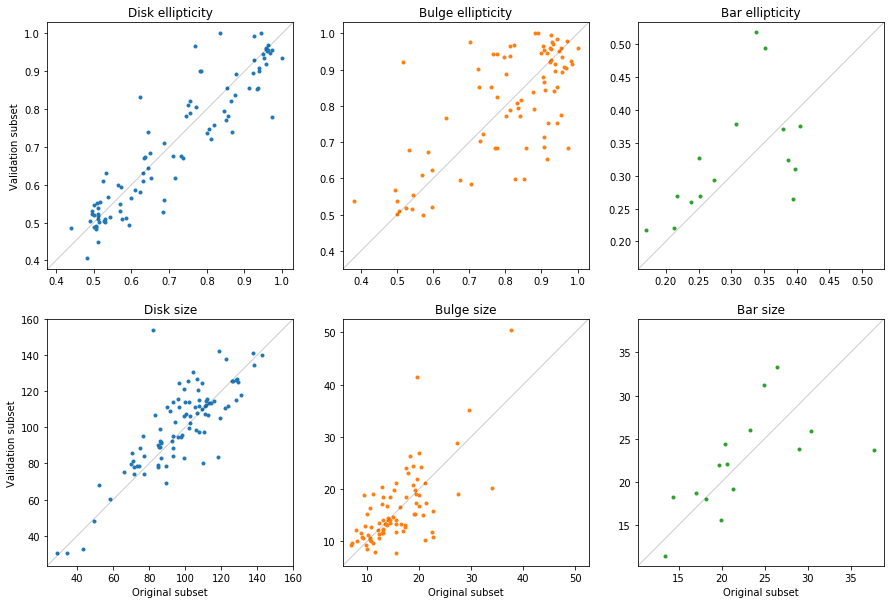

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax_disk, ax_bulge, ax_bar = np.array(axes).T
# Disk
ax = ax_disk
ax[0].plot(
    gzb_models.loc[ss_ids]['disk-axRatio'],
    gzb_models.loc[validation_ids]['disk-axRatio'],
    '.', c='C0',
)
ax[1].plot(
    gzb_models.loc[ss_ids]['disk-rEff'],
    gzb_models.loc[validation_ids]['disk-rEff'],
    '.', c='C0',
)
ax[0].set_title('Disk ellipticity')
ax[1].set_title('Disk size')
for a in ax:
    a.set_ylabel('Validation subset');
ax[1].set_xlabel('Original subset')

# Bulge
ax = ax_bulge
ax[0].plot(
    gzb_models.loc[ss_ids]['bulge-axRatio'],
    gzb_models.loc[validation_ids]['bulge-axRatio'],
    '.', c='C1',
)
ax[1].plot(
    gzb_models.loc[ss_ids]['bulge-rEff'],
    gzb_models.loc[validation_ids]['bulge-rEff'],
    '.', c='C1',
)
ax[0].set_title('Bulge ellipticity')
ax[1].set_title('Bulge size')
ax[1].set_xlabel('Original subset')

# Bar
ax = ax_bar
ax[0].plot(
    gzb_models.loc[ss_ids]['bar-axRatio'],
    gzb_models.loc[validation_ids]['bar-axRatio'],
    '.', c='C2',
)
ax[1].plot(
    gzb_models.loc[ss_ids]['bar-rEff'],
    gzb_models.loc[validation_ids]['bar-rEff'],
    '.', c='C2',
)
ax[0].set_title('Bar ellipticity')
ax[1].set_title('Bar size')
ax[1].set_xlabel('Original subset')

for ax in (ax_disk, ax_bulge, ax_bar):
    for a in ax:
        l = a.get_xlim() + a.get_ylim()
        lims = min(l), max(l)
        a.plot((-1e3, 1e3), (-1e3, 1e3), 'k', alpha=0.2, linewidth=1)
        a.set_xlim(lims); a.set_ylim(lims)

plt.savefig('duplicates_plots/component_sizing.pdf', bbox_inches='tight')

And spiral arm pitch angles?

In [18]:
def get_pa(sid):
    arms = [
        Arm.load(os.path.join('lib/spiral_arms', f))
        for f in os.listdir('lib/spiral_arms')
        if re.match(r'{}-[0-9]+\.pickle'.format(sid), f)
    ]
    if not len(arms) > 0:
        return np.nan, np.nan
    p = arms[0].get_parent()
    return p.get_pitch_angle(arms) + (len(arms),)

pa_original = pd.DataFrame(
    list(map(get_pa, ss_ids)),
    columns=('pa', 'sigma_pa', 'n_arms'),
    index=dr8ids,
)
pa_validation = pd.DataFrame(
    list(map(get_pa, validation_ids)),
    columns=('pa', 'sigma_pa', 'n_arms'),
    index=dr8ids,
)

In [26]:
mask = pa_original['n_arms'] == pa_validation['n_arms']

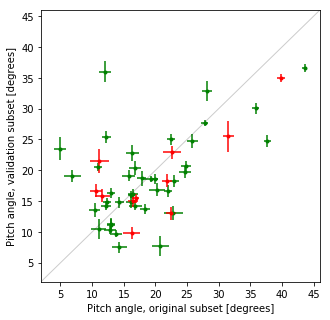

In [29]:
plt.figure(figsize=(5, 5))
mask = pa_original['n_arms'] == pa_validation['n_arms']
plt.errorbar(
    pa_original[mask].iloc[:, 0],
    pa_validation[mask].iloc[:, 0],
    xerr=pa_original[mask].iloc[:, 1],
    yerr=pa_validation[mask].iloc[:, 1],
    fmt='g.'
)
plt.errorbar(
    pa_original[~mask].iloc[:, 0],
    pa_validation[~mask].iloc[:, 0],
    xerr=pa_original[~mask].iloc[:, 1],
    yerr=pa_validation[~mask].iloc[:, 1],
    fmt='r.'
)
l = plt.xlim() + plt.ylim()
lims = min(l), max(l)
plt.plot((-90, 90), (-90, 90), 'k', alpha=0.2, linewidth=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Pitch angle, original subset [degrees]')
plt.ylabel('Pitch angle, validation subset [degrees]')
plt.savefig('duplicates_plots/pa_comparison.pdf', bbox_inches='tight')

In [38]:
foo = pa_original.query('pa < 5').index
pa_original.loc[foo], pa_validation.loc[foo]

(                          pa  sigma_pa  n_arms
 587741600952615088  4.910154  0.994989     1.0,
                           pa  sigma_pa  n_arms
 587741600952615088  23.52517  1.876439     1.0)

In [41]:
ss_ids[dr8ids == 587741600952615088], validation_ids[dr8ids == 587741600952615088]

(array([20902000]), array([21686510]))